In [1]:
# ============================================================================
# PROJECT FOLDER STRUCTURE
# ============================================================================
# game-behavior-analytics/
# ├── data_analysis_notebook/
# │   └── analysis(PL+SM).ipynb
# ├── data/
# │   └── final_dataset.csv

# Change to the correct directory
%cd game-behavior-analytics/data_analysis_notebook/ 

/Users/suvadeep.mukherjee/Documents/game-behavior-intervention-study/game-behavior-analytics/data_analysis_notebook


/opt/anaconda3/envs/cheating_env/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


### Cell 1: Setup and Data Preparation

In [2]:

# ============================================================================
# LIBRARY IMPORTS
# ============================================================================

import pandas as pd
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import stats
import os
import seaborn as sns

os.getcwd()

'/Users/suvadeep.mukherjee/Documents/game-behavior-intervention-study/game-behavior-analytics/data_analysis_notebook'

In [3]:

# ============================================================================
# DATA PREPARATION
# ============================================================================

df = pd.read_csv("../data/final_dataset.csv")

# Create categorical cheating behavior variable
def cheating_behavior(cheating_rate):
    return 0 if cheating_rate == 0 else (2 if cheating_rate == 1 else 1)  # Non-cheater=0, Full cheater=2, Partial cheater=1

df["cheating_behavior"] = df["cheating_rate_main_round"].apply(cheating_behavior)  # algorithm is in {game-behavior-analytics/cheating_analysis/cheating_analyzer.py}
df["experience"] = (df["task_satisfaction"] + df["task_engagement"]) / 2  # average of task satisfaction and task engagement
df["performance"] = df["performance_score_including_cheated_words"]  # performance includes legitimate + cheated words

# Drop rows with missing key outcome or predictor variables
df = df.dropna(subset=['cheating_behavior', 'performance', 'experience', 'concept', 'motivational_message_id'])


# Prepare data splits
control_data = df[df['concept'] == 'control']
intervention_data = df[df['concept'] != 'control']

# We use this naming convention:
# Intervention (1=concept-based message shown; 0=control) → Concept (15 concepts from 4 theories) → Motivational Message (3 variations per concept)

concept_ids = df['concept'].astype('category')
if concept_ids.cat.categories[0] != 'control':
    concept_ids = concept_ids.cat.reorder_categories(['control'] + [c for c in concept_ids.cat.categories if c != 'control'])
concept_codes = concept_ids.cat.codes.values
concepts = [c for c in concept_ids.cat.categories if c != 'control']

message_ids = df['motivational_message_id'].astype('category')
message_codes = message_ids.cat.codes.values

# Extract outcome and predictor arrays
y_cheating_behavior = df['cheating_behavior'].values
y_performance = df['performance'].values
y_experience = df['experience'].values
is_partialCheater, is_fullCheater = (y_cheating_behavior == 1).astype(int), (y_cheating_behavior == 2).astype(int)

# Standard deviations
perf_std, exp_std = np.std(y_performance), np.std(y_experience)


# ============================================================================
# CHEATING DISTRIBUTION IN INTERVENTION GROUPS
# ============================================================================
cheating_distribution = df.groupby('concept')['cheating_behavior'].value_counts().unstack(fill_value=0)
cheating_distribution = cheating_distribution.reindex(['control'] + [c for c in concepts if c != 'control'], fill_value=0)
cheating_distribution.index.name = 'Concept'
cheating_distribution.columns = ['Non-Cheater', 'Partial Cheater', 'Full Cheater']
cheating_distribution = cheating_distribution.reset_index()
cheating_distribution.loc['Total'] = cheating_distribution.sum()
cheating_distribution.loc['Total', 'Concept'] = 'Total'

print("Cheating distribution in intervention groups:")
print(cheating_distribution)


Cheating distribution in intervention groups:
                              Concept  Non-Cheater  Partial Cheater  \
0                             control           39               10   
1                            autonomy           50               15   
2             cognitive_inconsistency           51               15   
3                          competence           51               10   
4                   descriptive_norms           51               17   
5                  dissonance_arousal           49                9   
6                dissonance_reduction           48               18   
7                   emotional_arousal           44               14   
8                    injunctive_norms           47               12   
9         performance_accomplishments           44               16   
10     reference_group_identification           55                9   
11                        relatedness           50               10   
12                       self_c

### Explorative Analysis: 1) Visualization of potential source of cheaters in intervention groups from control's performance distribution

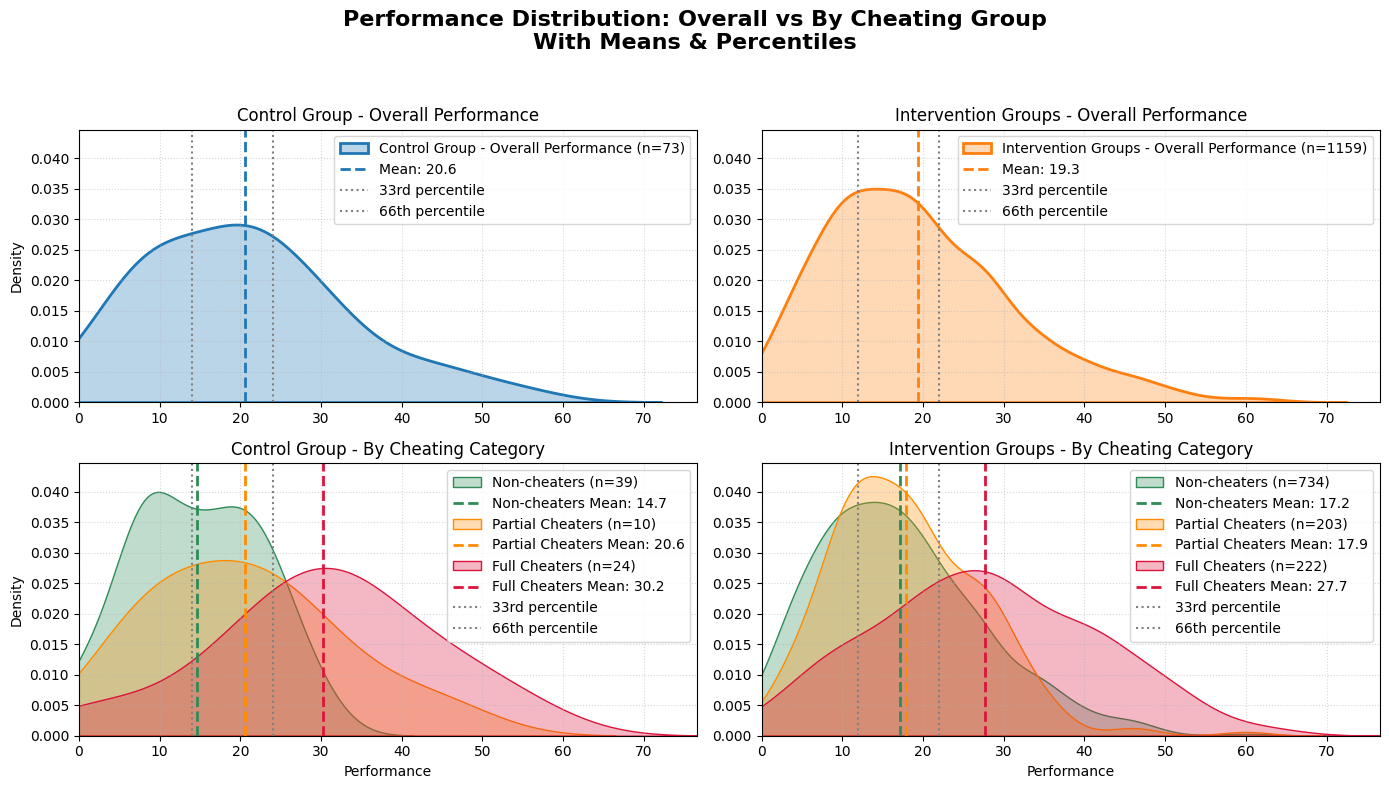


PERFORMANCE SUMMARY TABLE:
          Group          Cheating    N       Mean        Std  Min  Max
0       Control      Non-cheaters   39  14.666667   7.911794    0   30
1       Control  Partial Cheaters   10  20.600000  11.852801    6   44
2       Control     Full Cheaters   24  30.250000  13.847775    0   56
3  Intervention      Non-cheaters  734  17.193460  10.370130    0   62
4  Intervention  Partial Cheaters  203  17.940887   9.182228    0   60
5  Intervention     Full Cheaters  222  27.729730  13.730401    0   64

DISTRIBUTION OF PERFORMANCE TYPES OVER CHEATING GROUPS IN CONTROL AND INTERVENTIONS, AND CHANGE IN EXPERIENCE
PERFORMANCE SCORE CATEGORIES (based on control group percentiles)
1. Low performance: scores at or below the 33rd percentile of control group (≤ 14.0); 
2. Medium performance: scores between the 33rd and 67th percentiles of control group (14.0 – 24.0)
3. High performance: scores above the 67th percentile of control group (> 24.0)

PERFORMANCE IN CONTROL:
       

In [4]:
# =======================================================================================
# PERFORMANCE DISTRIBUTIONS FOR CONTROL vs INTERVENTION GROUPS
# =======================================================================================

# Define labels and colors
cheating_labels = {0: 'Non-cheaters', 1: 'Partial Cheaters', 2: 'Full Cheaters'}
colors = ['#2E8B57', '#FF8C00', '#DC143C']


# Function to plot overall performance with mean + 33rd,66th percentiles
def plot_overall(ax, data, title, color):
    subset = data['performance'].dropna()
    subset = subset[subset >= 0]
    if len(subset) < 3:
        return
    
    sns.kdeplot(subset, ax=ax, fill=True, alpha=0.3, color=color, linewidth=2, label=f"{title} (n={len(subset)})")
    
    # Mean line
    mean_val = subset.mean()
    ax.axvline(mean_val, color=color, linestyle='--', linewidth=2, label=f"Mean: {mean_val:.1f}")
    
    # 33rd and 66th percentile lines
    p33, p66 = np.percentile(subset, [33,66])
    ax.axvline(p33, color='gray', linestyle=':', linewidth=1.5, label='33rd percentile')
    ax.axvline(p66, color='gray', linestyle=':', linewidth=1.5, label='66th percentile')
    
    ax.set_title(title)
    ax.set_xlabel('Performance')
    ax.set_xlim(left=0)
    ax.legend()
    ax.grid(True, linestyle=':', alpha=0.5)

# Function to plot performance by cheating category with individual means
def plot_by_cheating(ax, data, title):
    for i, cheat_cat in enumerate([0,1,2]):
        subset = data[data['cheating_behavior'] == cheat_cat]['performance'].dropna()
        subset = subset[subset >= 0]
        if len(subset) > 3:
            sns.kdeplot(subset, ax=ax, label=f"{cheating_labels[cheat_cat]} (n={len(subset)})", fill=True, alpha=0.3, color=colors[i])
            
            # Mean line per cheating group
            mean_val = subset.mean()
            ax.axvline(mean_val, color=colors[i], linestyle='--', linewidth=2, label=f"{cheating_labels[cheat_cat]} Mean: {mean_val:.1f}")
    
    # Overall percentiles
    overall_subset = data['performance'].dropna()
    overall_subset = overall_subset[overall_subset >= 0]
    if len(overall_subset) >= 3:
        p33, p66 = np.percentile(overall_subset, [33,66])
        ax.axvline(p33, color='gray', linestyle=':', linewidth=1.5, label='33rd percentile')
        ax.axvline(p66, color='gray', linestyle=':', linewidth=1.5, label='66th percentile')
    
    ax.set_title(title)
    ax.set_xlabel('Performance')
    ax.set_xlim(left=0)
    ax.legend()
    ax.grid(True, linestyle=':', alpha=0.5)

# =======================================================================================
# PLOTTING IN 2x2 GRID
# =======================================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=True, sharey=True)
fig.suptitle('Performance Distribution: Overall vs By Cheating Group\nWith Means & Percentiles', fontsize=16, fontweight='bold')

# First row: overall distributions
plot_overall(axes[0,0], control_data, 'Control Group - Overall Performance', '#1f77b4')
plot_overall(axes[0,1], intervention_data, 'Intervention Groups - Overall Performance', '#ff7f0e')

# Second row: distributions by cheating group
plot_by_cheating(axes[1,0], control_data, 'Control Group - By Cheating Category')
plot_by_cheating(axes[1,1], intervention_data, 'Intervention Groups - By Cheating Category')

for ax in axes[0,:]:
    ax.tick_params(axis='x', which='both', labelbottom=True)
for ax in axes.flatten():
    ax.tick_params(axis='y', which='both', labelleft=True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# =======================================================================================
# PERFORMANCE SUMMARY TABLE
# =======================================================================================

def performance_summary_table(data, group_name):
    """Returns mean, std, min, max per cheating category"""
    rows = []
    for cheat_cat in [0,1,2]:
        subset = data[data['cheating_behavior'] == cheat_cat]['performance'].dropna()
        subset = subset[subset >= 0]
        if len(subset) > 0:
            rows.append({
                'Group': group_name,
                'Cheating': cheating_labels[cheat_cat],
                'N': len(subset),
                'Mean': subset.mean(),
                'Std': subset.std(),
                'Min': subset.min(),
                'Max': subset.max()
            })
    return pd.DataFrame(rows)

# Combine summaries for control and interventions
control_summary = performance_summary_table(control_data, 'Control')
intervention_summary = performance_summary_table(intervention_data, 'Intervention')
summary_df = pd.concat([control_summary, intervention_summary], ignore_index=True)

print("\nPERFORMANCE SUMMARY TABLE:")
print(summary_df)

# =======================================================================================
# PERFORMANCE ANALYSIS TABLE
# =======================================================================================

# Define control performance percentiles
control_performance = df[df['concept'] == 'control']['performance'].dropna()
control_performance = control_performance[control_performance >= 0]
p33, p67 = np.percentile(control_performance, [33, 67])

print("\n" + "="*100)
print("DISTRIBUTION OF PERFORMANCE TYPES OVER CHEATING GROUPS IN CONTROL AND INTERVENTIONS, AND CHANGE IN EXPERIENCE")
print("="*100)
print("PERFORMANCE SCORE CATEGORIES (based on control group percentiles)")
print(f"1. Low performance: scores at or below the 33rd percentile of control group (≤ {p33:.1f}); ")
print(f"2. Medium performance: scores between the 33rd and 67th percentiles of control group ({p33:.1f} – {p67:.1f})")
print(f"3. High performance: scores above the 67th percentile of control group (> {p67:.1f})")

# Categorise all participants based on these bins
def get_performance_category(perf):
    if perf <= p33:
        return 'Low'
    elif perf <= p67:
        return 'Medium'
    else:
        return 'High'

df['performance_category'] = df['performance'].apply(lambda x: get_performance_category(x) if x >= 0 else np.nan)

# Set ordered categorical dtype to control sorting
category_order = ['Low', 'Medium', 'High']
df['performance_category'] = pd.Categorical(df['performance_category'], categories=category_order, ordered=True)

# Now when you do crosstabs, the order will be respected
control_data = df[df['concept'] == 'control'].copy()
intervention_data = df[df['concept'] != 'control'].copy()

def make_crosstab(data, name):
    crosstab = pd.crosstab(data['performance_category'], data['cheating_behavior'], normalize='index') * 100
    crosstab.columns = ['Non-Cheater(%)', 'Partial Cheater(%)', 'Full Cheater(%)']
    print(f"\n{name}:")
    print(crosstab.round(1))
    return crosstab
print("="*100)
control_tab = make_crosstab(control_data, "PERFORMANCE IN CONTROL")
intervention_tab = make_crosstab(intervention_data, "PERFORMANCE IN INTERVENTIONS")

change = intervention_tab - control_tab
print(f"\nCHANGE (INTERVENTION - CONTROL):")
print(change.round(2))
print("="*100)

# =======================================================================================
# EXPERIENCE ANALYSIS TABLE - MEAN RATINGS BY PERFORMER TYPES × CHEATING GROUPS
# =======================================================================================

# Create crosstabs showing MEAN EXPERIENCE for each performance-cheating combination
def make_experience_mean_crosstab(data, name):
    # Group by performance category and cheating behavior, calculate mean experience
    mean_table = (
        data.groupby(['performance_category', 'cheating_behavior'], observed=True)['experience']
        .mean()
        .round(2)
        .unstack(fill_value=np.nan)
    )
    
    mean_table.columns = ['Non-Cheater', 'Partial Cheater', 'Full Cheater']
    
    print(f"\n{name} - MEAN EXPERIENCE RATINGS:")
    print(mean_table)
    
    return mean_table

# Create tables for control and intervention groups
control_exp_mean = make_experience_mean_crosstab(control_data, "EXPERIENCE IN CONTROL")
intervention_exp_mean = make_experience_mean_crosstab(intervention_data, "EXPERIENCE IN INTERVENTIONS")

# Calculate and print the difference (Intervention - Control)
exp_mean_change = intervention_exp_mean - control_exp_mean
print(f"\nCHANGE (INTERVENTION - CONTROL):")
print(exp_mean_change.round(2))
print("="*100)


#### Interpretation of the results above:

1. High performers can have **biggest impacts by interventions**
    - In the control, ~70% of high performers were full cheaters. Under intervention, this dropped dramatically to ~40% (↓30%).
    - The non-cheater proportion among high performers nearly tripled (~18% → ~47%). That ~30% could have moved from full cheaters to non-cheaters.
    - Interpretation: 
        - The interventions substantially could reduce cheating among high performers. It suggests that high performers might have the skills to achieve high scores without cheating but chose to cheat in control.
        - Under interventions (e.g. motivational messaging), they may choose honesty over maximizing scores without sacrificing experience (ΔExperience ≈ 0).

2. Medium performers can show **smaller cheating reductions**, but can show interesting patterns:
    - Full cheaters among medium performers reduced slightly (~23% → ~15%), a -8% change.
    - Partial cheaters increased (~14% → 20%, +6%).
    - Interpretation: 
        - Some full cheaters may have downgraded to partial cheating, and a small portion could become fully honest (non-cheaters ↑~2%).
        - Experience ratings for full cheaters in this group increased by +0.55, suggesting that interventions might have been helping them to be better engaged and satisfied.

3. Low performers were already **mostly honest**
    - Both in control and intervention, ~75% were non-cheaters. Very little change in cheating behavior:
        - Full cheaters reduced by only ~2%.
        - Partial cheaters increased by ~4% (from non-cheaters or full cheaters).
    - Experience: Low performer partial cheaters experienced a 1-point drop in experience under intervention.
        - This might imply: Messaging or intervention-induced guilt or inadequacy feelings among low performers who still cheated partially.


#### Key Takeaways:
##### Our interventions may not make weaker players cheat more if they are already mostly honest. The most notable effect we could see among high performers, where cheating can drastically be reduced under interventions without harming their experience. This suggests that behavioral interventions can transform those with the greatest capacity to cheat without diminishing their task engagement or satisfaction.

### Next, we will run the Bayesian models to quantify these effects and understand the underlying mechanisms.

- Intervention model: This model will estimate the impact of interventions on cheating behavior, performance, and experience ratings.
- Concept model: This model will estimate concept-specific effects on cheating behavior, performance, and experience ratings, allowing us to understand how different concepts influence these outcomes.

In [6]:
# ============================================================================
# CONTROL BASELINES CALCULATION (Will be used as intercept in models)
# ============================================================================

control_cheating = control_data['cheating_behavior'].mean()
control_performance = control_data['performance'].mean()
control_experience = control_data['experience'].mean()
# Convert control cheating to log-odds for ordered logistic
control_logit = np.log(control_cheating / (1 - control_cheating)) if control_cheating != 0 else -2

#### MODEL 1: OVERALL INTERVENTION EFFECT vs CONTROL

In [23]:
# ============================================================================
# MODEL 1 SPECIFICATION
# ============================================================================

# Create intervention indicator (1 = any concept-based intervention, 0 = control)
df['is_intervention'] = (df['concept'] != 'control').astype(int)
intervention_indicator = df['is_intervention'].values

with pm.Model() as intervention_model:
    
    # ----------------------------------------
    # MODEL 1A: CHEATING BEHAVIOR (Ordered Logistic)
    # log_odds(cheating) = β₀ + β_intervention×Intervention + message_effects
    # ----------------------------------------
    
    cutpoints = pm.Normal('cutpoints', mu=[-0.8, 0.2], sigma=0.5, shape=2, transform=pm.distributions.transforms.ordered)
    
    # Control baseline
    beta_cheat_intercept = pm.Normal('beta_cheat_intercept', mu=control_logit, sigma=1.0)
    
    # Overall intervention effect vs control
    beta_cheat_intervention = pm.Normal('beta_cheat_intervention', mu=-1.29, sigma=1.2)
    
    # Message effects
    msg_effect_cheat = pm.Normal('msg_effect_cheat', mu=0, sigma=pm.HalfNormal('sigma_msg_cheat', sigma=0.5), shape=len(message_ids.cat.categories))

    # Linear predictor
    eta_cheat = (beta_cheat_intercept + 
                 beta_cheat_intervention * intervention_indicator +
                 msg_effect_cheat[message_codes])

    pm.OrderedLogistic('cheating_behavior', cutpoints=cutpoints, eta=eta_cheat, observed=y_cheating_behavior)

    # ----------------------------------------
    # MODEL 1B: PERFORMANCE (Truncated Normal)
    # Performance = β₀ + β_intervention×Intervention + message_effects + ε
    # ----------------------------------------

    # Control baseline
    beta_perf_intercept = pm.Normal('beta_perf_intercept', mu=control_performance, sigma=1.0)
    
    # Overall intervention effect vs control
    beta_perf_intervention = pm.Normal('beta_perf_intervention', mu=0, sigma=perf_std)
    
    # Message effects
    msg_effect_perf = pm.Normal('msg_effect_perf', mu=0, sigma=pm.HalfNormal('sigma_msg_perf', sigma=perf_std/4), shape=len(message_ids.cat.categories))

    # Linear predictor
    mu_perf = (beta_perf_intercept +
               beta_perf_intervention * intervention_indicator +
               msg_effect_perf[message_codes])

    pm.TruncatedNormal('performance', mu=mu_perf, 
                      sigma=pm.HalfNormal('sigma_perf', sigma=perf_std),
                      lower=0, upper=y_performance.max() + 2*perf_std,
                      observed=y_performance)

    # ----------------------------------------
    # MODEL 1C: EXPERIENCE (Truncated Normal)
    # Experience = γ₀ + γ_intervention×Intervention + message_effects + ε
    # ----------------------------------------

    # Control baseline
    beta_exp_intercept = pm.Normal('beta_exp_intercept', mu=control_experience, sigma=0.5)
    
    # Overall intervention effect vs control
    beta_exp_intervention = pm.Normal('beta_exp_intervention', mu=0, sigma=exp_std/2)
    
    # Message effects
    msg_effect_exp = pm.Normal('msg_effect_exp', mu=0, sigma=pm.HalfNormal('sigma_msg_exp', sigma=exp_std/4), shape=len(message_ids.cat.categories))

    # Linear predictor
    mu_exp = (beta_exp_intercept +
              beta_exp_intervention * intervention_indicator +
              msg_effect_exp[message_codes])

    pm.TruncatedNormal('experience', mu=mu_exp, 
                      sigma=pm.HalfNormal('sigma_exp', sigma=exp_std/2),
                      lower=1, upper=7,
                      observed=y_experience)

print("Intervention model specification complete!")


Intervention model specification complete!


In [24]:
# ============================================================================
# FIT MODEL 1: INTERVENTION vs CONTROL
# ============================================================================

print("\nFitting Model 1: Overall Intervention Effect...")
with intervention_model:
    trace_intervention = pm.sample(1000, tune=500, chains=4, cores=4, target_accept=0.9, random_seed=42)
print("Model 1 fitted successfully!")


# ============================================================================
# MODEL 1 RESULTS
# ============================================================================

print("\n" + "="*80)
print("MODEL 1 RESULTS: OVERALL INTERVENTION EFFECTS")
print("="*80)

# Extract intervention effects
intervention_summary = az.summary(trace_intervention, hdi_prob=0.95)

print("CHEATING BEHAVIOR:")
cheat_effect = intervention_summary.loc['beta_cheat_intervention', 'mean']
cheat_hdi = intervention_summary.loc['beta_cheat_intervention', ['hdi_2.5%', 'hdi_97.5%']].values
cheat_samples = trace_intervention.posterior['beta_cheat_intervention'].values.flatten()
cheat_prob_decrease = (cheat_samples < 0).mean()
cheat_d = cheat_samples * np.sqrt(3) / np.pi
print(f"  Effect: {cheat_effect:.3f} [{cheat_hdi[0]:.3f}, {cheat_hdi[1]:.3f}]")
print(f"  Cohen's d: {cheat_d.mean():.3f} [{np.percentile(cheat_d, 2.5):.3f}, {np.percentile(cheat_d, 97.5):.3f}]")
print(f"  P(reduction): {cheat_prob_decrease:.3f}")

print("\nPERFORMANCE:")
perf_effect = intervention_summary.loc['beta_perf_intervention', 'mean']
perf_hdi = intervention_summary.loc['beta_perf_intervention', ['hdi_2.5%', 'hdi_97.5%']].values
perf_samples = trace_intervention.posterior['beta_perf_intervention'].values.flatten()
perf_prob_increase = (perf_samples > 0).mean()
perf_d = perf_samples / perf_std
print(f"  Effect: {perf_effect:.3f} [{perf_hdi[0]:.3f}, {perf_hdi[1]:.3f}]")
print(f"  Cohen's d: {perf_d.mean():.3f} [{np.percentile(perf_d, 2.5):.3f}, {np.percentile(perf_d, 97.5):.3f}]")
print(f"  P(improvement): {perf_prob_increase:.3f}")

print("\nEXPERIENCE:")
exp_effect = intervention_summary.loc['beta_exp_intervention', 'mean']
exp_hdi = intervention_summary.loc['beta_exp_intervention', ['hdi_2.5%', 'hdi_97.5%']].values
exp_samples = trace_intervention.posterior['beta_exp_intervention'].values.flatten()
exp_prob_increase = (exp_samples > 0).mean()
exp_d = exp_samples / exp_std
print(f"  Effect: {exp_effect:.3f} [{exp_hdi[0]:.3f}, {exp_hdi[1]:.3f}]")
print(f"  Cohen's d: {exp_d.mean():.3f} [{np.percentile(exp_d, 2.5):.3f}, {np.percentile(exp_d, 97.5):.3f}]")
print(f"  P(improvement): {exp_prob_increase:.3f}")


Fitting Model 1: Overall Intervention Effect...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cutpoints, beta_cheat_intercept, beta_cheat_intervention, sigma_msg_cheat, msg_effect_cheat, beta_perf_intercept, beta_perf_intervention, sigma_msg_perf, msg_effect_perf, sigma_perf, beta_exp_intercept, beta_exp_intervention, sigma_msg_exp, msg_effect_exp, sigma_exp]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 375 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Model 1 fitted successfully!

MODEL 1 RESULTS: OVERALL INTERVENTION EFFECTS
CHEATING BEHAVIOR:
  Effect: -0.664 [-1.122, -0.179]
  Cohen's d: -0.366 [-0.629, -0.107]
  P(reduction): 0.997

PERFORMANCE:
  Effect: -4.427 [-6.615, -2.160]
  Cohen's d: -0.378 [-0.576, -0.191]
  P(improvement): 0.000

EXPERIENCE:
  Effect: 0.076 [-0.220, 0.342]
  Cohen's d: 0.094 [-0.254, 0.442]
  P(improvement): 0.707


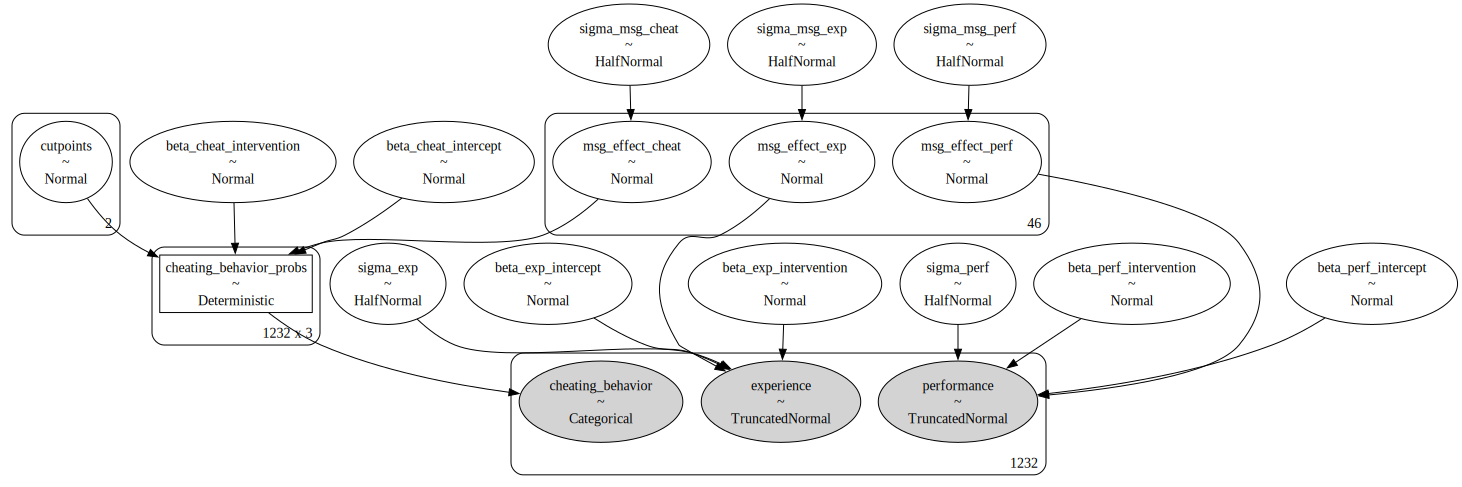

In [26]:
# ============================================================================
# GRAPHICAL REPRESENTATION OF MODEL 1
# ============================================================================

pm.model_to_graphviz(intervention_model)

Sampling: [cheating_behavior, experience, performance]


Output()

array([<Axes: xlabel='cheating_behavior'>, <Axes: xlabel='performance'>,
       <Axes: xlabel='experience'>], dtype=object)

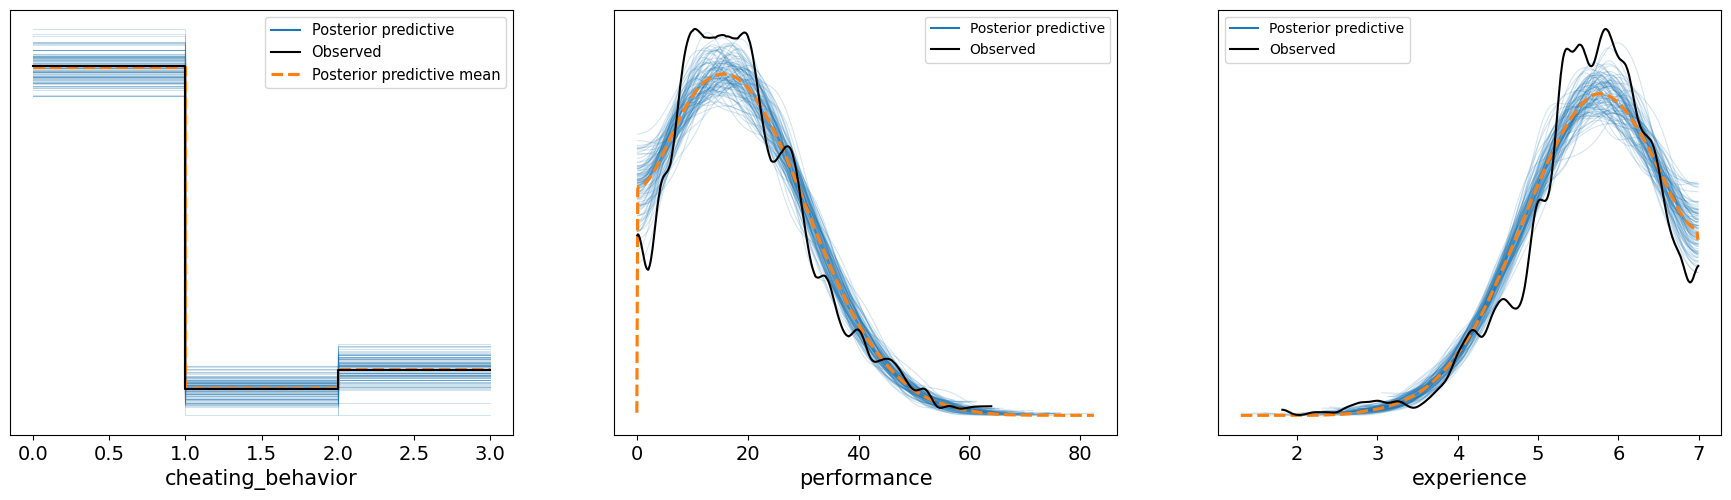

In [27]:
# ============================================================================
# ROBUST MODEL 1 CHECKING
# ============================================================================

# Posterior predictive checks
with intervention_model:
    ppc = pm.sample_posterior_predictive(trace_intervention)
    
# Check if model captures data patterns
az.plot_ppc(ppc, num_pp_samples=100)

#### MODEL 2: CONCEPT-SPECIFIC EFFECTS vs CONTROL

In [ ]:
# ============================================================================
# MODEL 2 SPECIFICATION
# ============================================================================

with pm.Model() as concept_model:
    
    # ----------------------------------------
    # MODEL 2A: CHEATING BEHAVIOR (Ordered Logistic)
    # log_odds(cheating) = β₀ + Σ(βᵢ×ConceptDummyᵢ) + message_effects
    # ----------------------------------------
    
    cutpoints = pm.Normal('cutpoints', mu=[-0.8, 0.2], sigma=0.5, shape=2, transform=pm.distributions.transforms.ordered)
    
    # Control baseline
    beta_cheat_intercept = pm.Normal('beta_cheat_intercept', mu=control_logit, sigma=1.0)
    
    # Individual concept effects vs control
    beta_cheat_concepts = pm.Normal('beta_cheat_concepts', mu=-1.29, sigma=1.2, shape=len(concepts))
    
    # Message effects
    msg_effect_cheat = pm.Normal('msg_effect_cheat', mu=0, sigma=pm.HalfNormal('sigma_msg_cheat', sigma=0.5), shape=len(message_ids.cat.categories))

    # Linear predictor
    eta_cheat = (beta_cheat_intercept + 
                 msg_effect_cheat[message_codes] + 
                 pm.math.switch(concept_codes > 0, beta_cheat_concepts[concept_codes - 1], 0))

    pm.OrderedLogistic('cheating_behavior', cutpoints=cutpoints, eta=eta_cheat, observed=y_cheating_behavior)

    # ----------------------------------------
    # MODEL 2B: PERFORMANCE (Truncated Normal)
    # Performance = β₀ + Σ(βᵢ×ConceptDummyᵢ) + message_effects + ε
    # ----------------------------------------

    # Control baseline
    beta_perf_intercept = pm.Normal('beta_perf_intercept', mu=control_performance, sigma=1.0)
    
    # Individual concept effects vs control
    beta_perf_concepts = pm.Normal('beta_perf_concepts', mu=0, sigma=perf_std, shape=len(concepts))
    
    # Message effects
    msg_effect_perf = pm.Normal('msg_effect_perf', mu=0, sigma=pm.HalfNormal('sigma_msg_perf', sigma=perf_std/4), shape=len(message_ids.cat.categories))

    # Linear predictor
    mu_perf = (beta_perf_intercept +
               msg_effect_perf[message_codes] +
               pm.math.switch(concept_codes > 0, beta_perf_concepts[concept_codes - 1], 0))

    pm.TruncatedNormal('performance', mu=mu_perf, 
                      sigma=pm.HalfNormal('sigma_perf', sigma=perf_std),
                      lower=0, upper=y_performance.max() + 2*perf_std,
                      observed=y_performance)

    # ----------------------------------------
    # MODEL 2C: EXPERIENCE (Truncated Normal)
    # Experience = γ₀ + Σ(γᵢ×ConceptDummyᵢ) + message_effects + ε
    # ----------------------------------------

    # Control baseline
    beta_exp_intercept = pm.Normal('beta_exp_intercept', mu=control_experience, sigma=0.5)
    
    # Individual concept effects vs control
    beta_exp_concepts = pm.Normal('beta_exp_concepts', mu=0, sigma=exp_std/2, shape=len(concepts))
    
    # Message effects
    msg_effect_exp = pm.Normal('msg_effect_exp', mu=0, sigma=pm.HalfNormal('sigma_msg_exp', sigma=exp_std/4), shape=len(message_ids.cat.categories))

    # Linear predictor
    mu_exp = (beta_exp_intercept +
              msg_effect_exp[message_codes] +
              pm.math.switch(concept_codes > 0, beta_exp_concepts[concept_codes - 1], 0))

    pm.TruncatedNormal('experience', mu=mu_exp, 
                      sigma=pm.HalfNormal('sigma_exp', sigma=exp_std/2),
                      lower=1, upper=7,
                      observed=y_experience)

print("Concept model specification complete!")


MODEL 2: CONCEPT-SPECIFIC EFFECTS vs CONTROL
Concept model specification complete!


In [22]:
# ============================================================================
# FIT MODEL 2: CONCEPTS vs CONTROL
# ============================================================================

print("\nFitting Model 2: Concept-Specific Effects...")
with concept_model:
    trace_concepts = pm.sample(1000, tune=500, chains=4, cores=4, target_accept=0.9, random_seed=42)
print("Model 2 fitted successfully!")


# ============================================================================
# MODEL 2 RESULTS
# ============================================================================

print("\n" + "="*80)
print("MODEL 2 RESULTS: CONCEPT-SPECIFIC EFFECTS")
print("="*80)

# Extract concept effects
concept_summary = az.summary(trace_concepts, hdi_prob=0.95)

# Theory mapping for display
theory_map = {
    "autonomy": "Self-Determination",
    "competence": "Self-Determination",
    "relatedness": "Self-Determination",
    "self_concept": "Cognitive Dissonance",
    "cognitive_inconsistency": "Cognitive Dissonance",
    "dissonance_arousal": "Cognitive Dissonance",
    "dissonance_reduction": "Cognitive Dissonance",
    "performance_accomplishments": "Self-Efficacy",
    "vicarious_experience": "Self-Efficacy",
    "verbal_persuasion": "Self-Efficacy",
    "emotional_arousal": "Self-Efficacy",
    "descriptive_norms": "Social Norms",
    "injunctive_norms": "Social Norms",
    "social_sanctions": "Social Norms",
    "reference_group_identification": "Social Norms"
}

def display_concept_effects(var_name, outcome, sd=None, is_logodds=False):
    print(f"\n{outcome}")
    print("=" * 100)
    print(f"{'Theory':20} {'Concept':25} {'Effect with 95% HDI':>25} {'Cohen\'s d with 95% HDI':>25} {'P(change)':>12}")
    print("-" * 100)
    
    posterior_samples = trace_concepts.posterior[var_name].values.reshape(-1, len(concepts))
    
    last_theory = None
    
    for concept in concepts:
        i = concepts.index(concept)
        theory = theory_map.get(concept, 'Unknown')
        
        param_name = f"{var_name}[{i}]"
        if param_name not in concept_summary.index:
            print(f"Warning: {param_name} not found in summary")
            continue
        
        mean = concept_summary.loc[param_name, 'mean']
        hdi = concept_summary.loc[param_name, ['hdi_2.5%', 'hdi_97.5%']].values
        
        concept_samples = posterior_samples[:, i]
        
        # Calculate probability and Cohen's d
        if is_logodds:
            prob_change = (concept_samples < 0).mean()
            d_samples = concept_samples * np.sqrt(3) / np.pi
        else:
            prob_change = (concept_samples > 0).mean()
            d_samples = concept_samples / sd if sd else concept_samples
        
        d_mean = d_samples.mean()
        d_hdi = np.percentile(d_samples, [2.5, 97.5])
        
        # Print theory header only when it changes
        theory_str = theory if theory != last_theory else ""
        last_theory = theory
        
        print(f"{theory_str:20} {concept:25} {mean:12.3f} [{hdi[0]:6.3f}, {hdi[1]:6.3f}]"
              f" {d_mean:12.3f} [{d_hdi[0]:6.3f}, {d_hdi[1]:6.3f}]"
              f" {prob_change:12.3f}")
    
    print("-" * 100)

# Display concept-specific results
display_concept_effects("beta_cheat_concepts", "CHEATING BEHAVIOR", is_logodds=True)
display_concept_effects("beta_perf_concepts", "PERFORMANCE", sd=perf_std)
display_concept_effects("beta_exp_concepts", "EXPERIENCE", sd=exp_std)



Fitting Model 2: Concept-Specific Effects...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cutpoints, beta_cheat_intercept, beta_cheat_concepts, sigma_msg_cheat, msg_effect_cheat, beta_perf_intercept, beta_perf_concepts, sigma_msg_perf, msg_effect_perf, sigma_perf, beta_exp_intercept, beta_exp_concepts, sigma_msg_exp, msg_effect_exp, sigma_exp]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 408 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Model 2 fitted successfully!

MODEL 2 RESULTS: CONCEPT-SPECIFIC EFFECTS

CHEATING BEHAVIOR
Theory               Concept                         Effect with 95% HDI    Cohen's d with 95% HDI    P(change)
----------------------------------------------------------------------------------------------------
Self-Determination   autonomy                        -1.081 [-1.697, -0.467]       -0.596 [-0.942, -0.261]        1.000
Cognitive Dissonance cognitive_inconsistency         -1.144 [-1.795, -0.529]       -0.631 [-0.987, -0.287]        1.000
Self-Determination   competence                      -1.012 [-1.629, -0.361]       -0.558 [-0.924, -0.222]        0.999
Social Norms         descriptive_norms               -0.993 [-1.581, -0.381]       -0.548 [-0.889, -0.227]        1.000
Cognitive Dissonance dissonance_arousal              -0.849 [-1.470, -0.248]       -0.468 [-0.830, -0.154]        0.999
                     dissonance_reduction            -0.921 [-1.523, -0.323]       -0.508 [-0.85

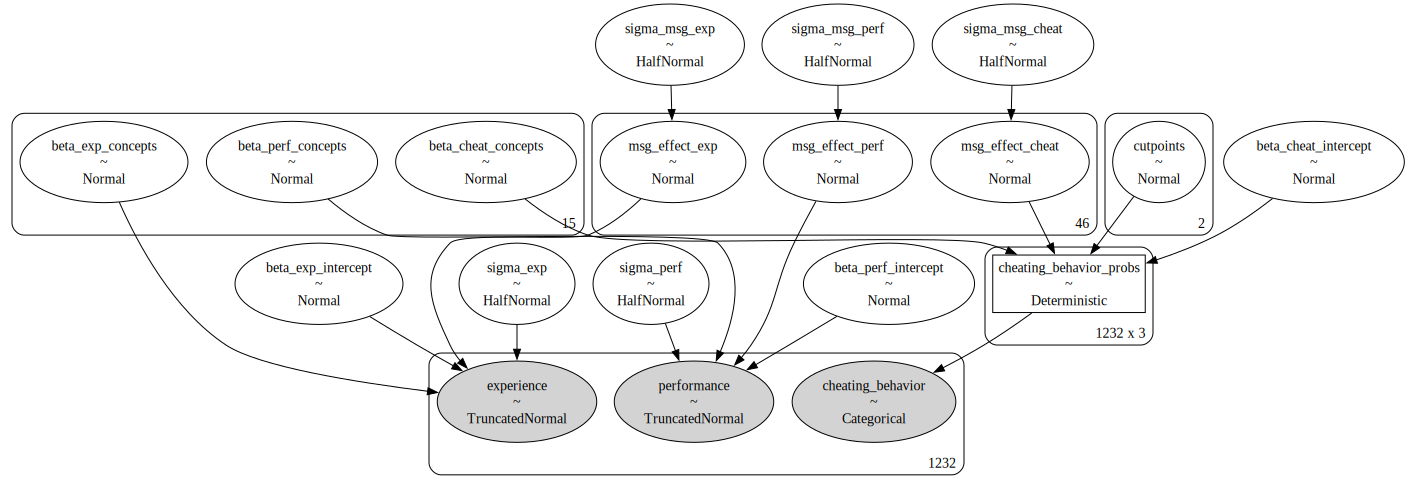

In [28]:
# ============================================================================
# GRAPHICAL REPRESENTATION OF MODEL 2
# ============================================================================

pm.model_to_graphviz(concept_model)

Sampling: [cheating_behavior, experience, performance]


Output()

array([<Axes: xlabel='cheating_behavior'>, <Axes: xlabel='performance'>,
       <Axes: xlabel='experience'>], dtype=object)

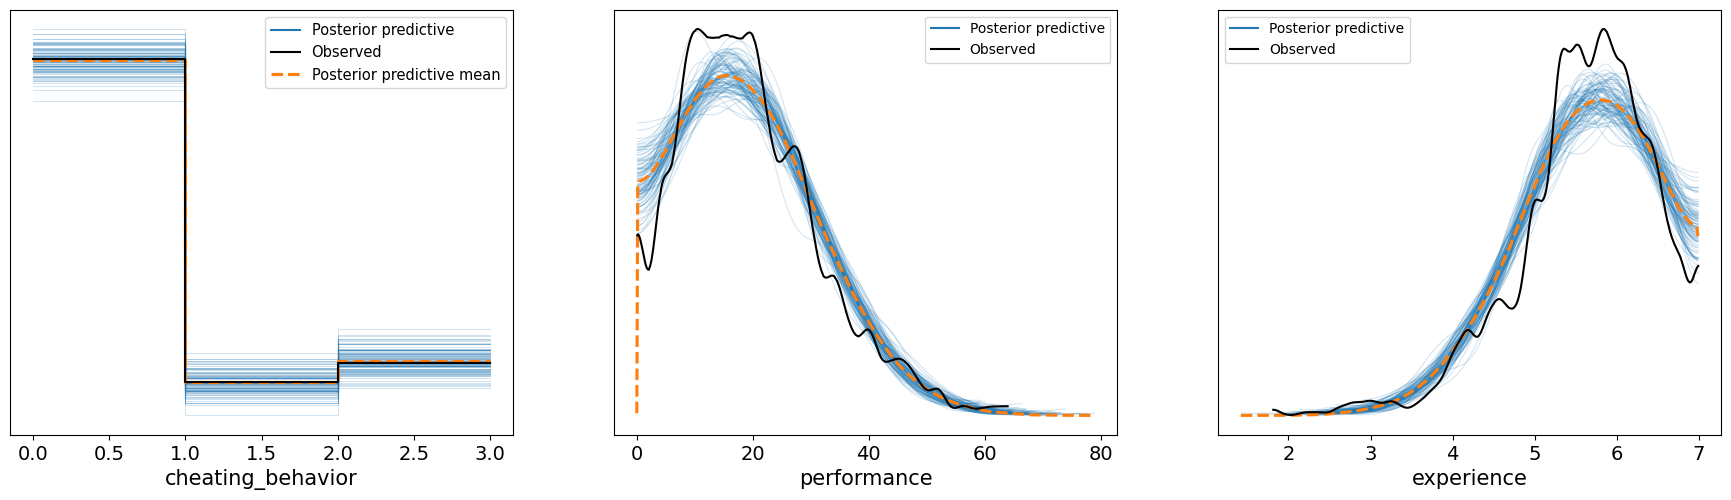

In [29]:
# ============================================================================
# ROBUST MODEL 2 CHECKING
# ============================================================================

# Posterior predictive checks
with concept_model:
    ppc = pm.sample_posterior_predictive(trace_concepts)
    
# Check if model captures data patterns
az.plot_ppc(ppc, num_pp_samples=100)

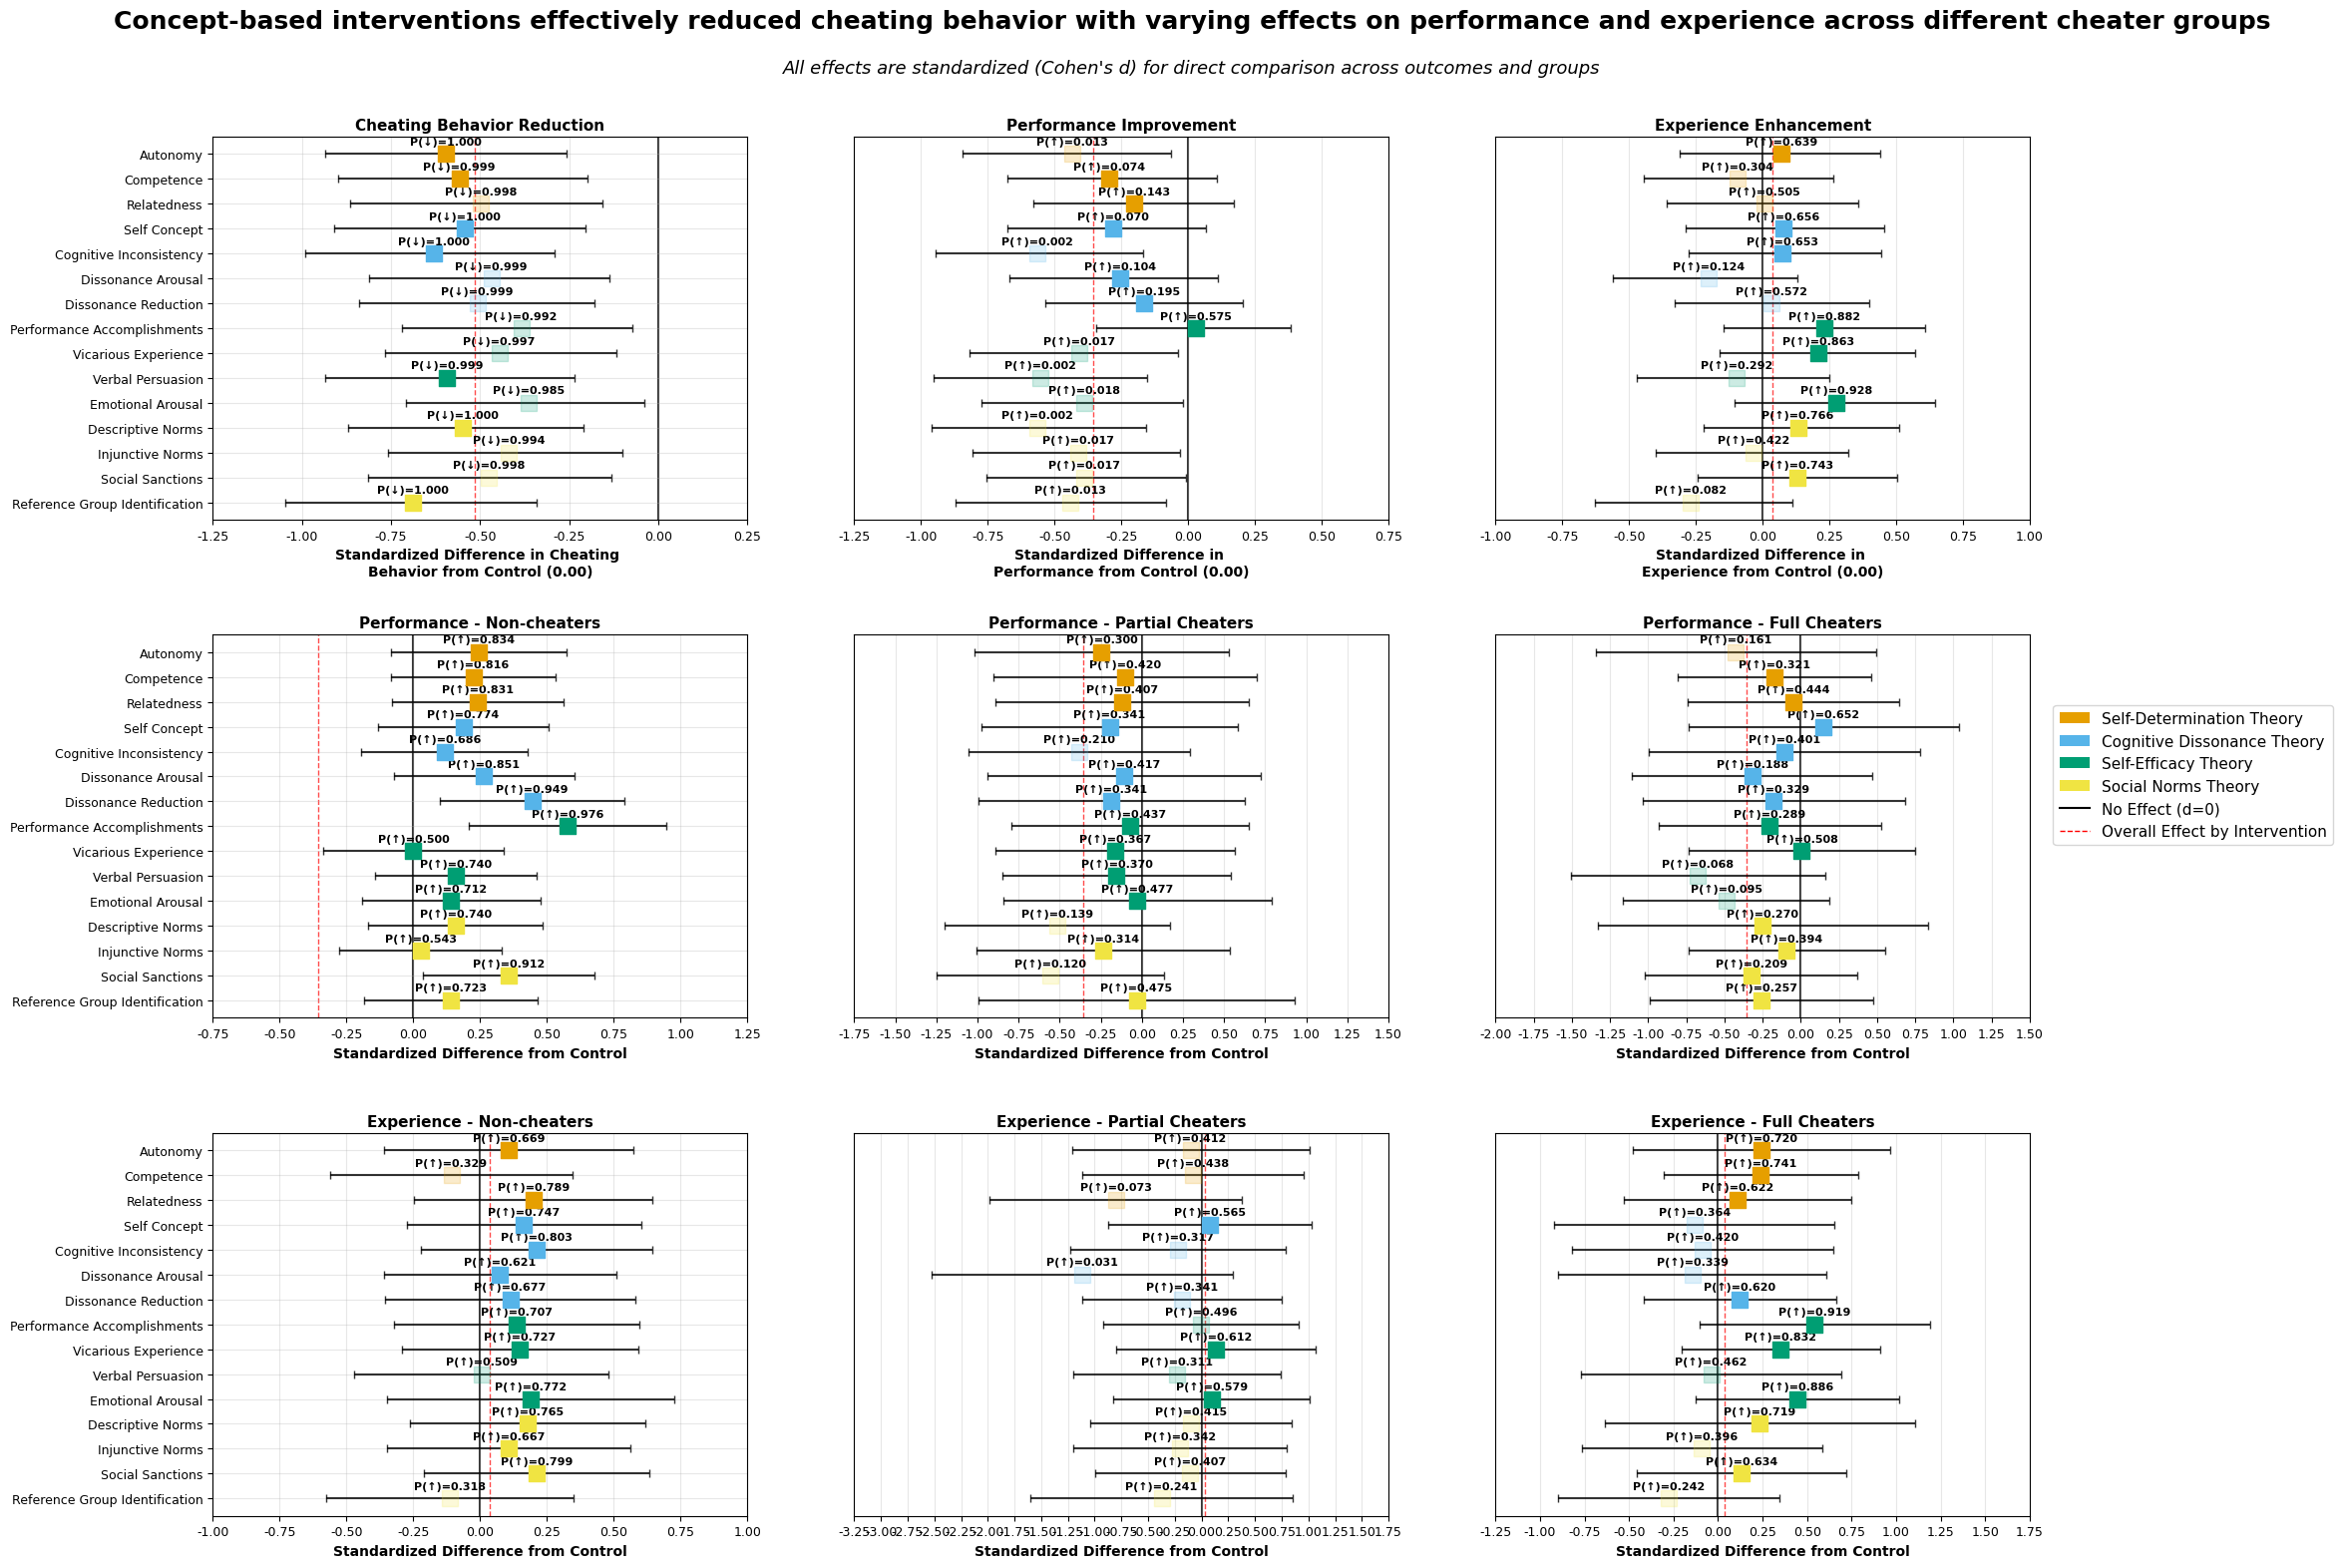

Overall Effects (Top Row):
  Cheating reduction from control: -0.515 (Cohen's d)
  Performance change from control: -0.355 (Cohen's d)
  Experience change from control: 0.036 (Cohen's d)


In [38]:
# ============================================================================
# RQ1 VISUALIZATION: 9-PLOT ANALYSIS (3 Overall + 6 By Cheater Groups)
# ============================================================================

from matplotlib.patches import Patch

# Theory colors and grouping
theory_colors = {
    "autonomy": "#E69F00", "competence": "#E69F00", "relatedness": "#E69F00",
    "self_concept": "#56B4E9", "cognitive_inconsistency": "#56B4E9", 
    "dissonance_arousal": "#56B4E9", "dissonance_reduction": "#56B4E9",
    "performance_accomplishments": "#009E73", "vicarious_experience": "#009E73", 
    "verbal_persuasion": "#009E73", "emotional_arousal": "#009E73",
    "descriptive_norms": "#F0E442", "injunctive_norms": "#F0E442", 
    "social_sanctions": "#F0E442", "reference_group_identification": "#F0E442"
}

theory_order = [
    "autonomy", "competence", "relatedness",  # Self-Determination
    "self_concept", "cognitive_inconsistency", "dissonance_arousal", "dissonance_reduction",  # Cognitive Dissonance
    "performance_accomplishments", "vicarious_experience", "verbal_persuasion", "emotional_arousal",  # Self-Efficacy
    "descriptive_norms", "injunctive_norms", "social_sanctions", "reference_group_identification"  # Social Norms
]

# Extract posterior samples from Model 2 (concept-specific effects)
beta_cheat = trace_concepts.posterior['beta_cheat_concepts'].values.reshape(-1, len(concepts))
beta_perf = trace_concepts.posterior['beta_perf_concepts'].values.reshape(-1, len(concepts))
beta_exp = trace_concepts.posterior['beta_exp_concepts'].values.reshape(-1, len(concepts))

# Calculate Cohen's d effect sizes and organize results
concept_results = {}
for i, name in enumerate(concepts):
    cheat_d = beta_cheat[:, i] * np.sqrt(3) / np.pi
    perf_d = beta_perf[:, i] / perf_std
    exp_d = beta_exp[:, i] / exp_std
    
    concept_results[name] = {
        'cheat_d': cheat_d.mean(),
        'cheat_d_hdi': az.hdi(cheat_d, hdi_prob=0.95),
        'cheat_prob_decrease': (beta_cheat[:, i] < 0).mean(),
        'perf_d': perf_d.mean(),
        'perf_d_hdi': az.hdi(perf_d, hdi_prob=0.95),
        'perf_prob_increase': (beta_perf[:, i] > 0).mean(),
        'exp_d': exp_d.mean(),
        'exp_d_hdi': az.hdi(exp_d, hdi_prob=0.95),
        'exp_prob_increase': (beta_exp[:, i] > 0).mean(),
        'color': theory_colors.get(name, '#999999')
    }

# Order results by theory grouping
results = []
for concept in reversed(theory_order):
    if concept in concept_results:
        r = concept_results[concept].copy()
        r['label'] = concept.replace('_', ' ').title()
        results.append(r)

# Calculate overall effects
overall_cheat_d = np.mean([beta_cheat[:, i] * np.sqrt(3) / np.pi for i in range(len(concepts))], axis=0).mean()
overall_perf_d = np.mean([beta_perf[:, i] / perf_std for i in range(len(concepts))], axis=0).mean()
overall_exp_d = np.mean([beta_exp[:, i] / exp_std for i in range(len(concepts))], axis=0).mean()

# Helper function for smart x-axis limits
def calculate_smart_xlim(results, effect_key, hdi_key, baseline=0.0, padding_factor=0.15):
    all_values = []
    for r in results:
        all_values += [r[effect_key], *r[hdi_key]]
    all_values.append(baseline)
    data_min, data_max = min(all_values), max(all_values)
    padding = max((data_max - data_min) * padding_factor, 0.05)
    xmin, xmax = data_min - padding, data_max + padding
    if abs(xmin - baseline) < padding * 0.5: xmin = baseline - padding
    if abs(xmax - baseline) < padding * 0.5: xmax = baseline + padding
    return xmin, xmax

# Function to create individual plot
def create_effect_plot(ax, results, effect_key, hdi_key, prob_key, title, subtitle, overall_mean, baseline=0.0, is_negative_better=False):
    xlim = calculate_smart_xlim(results, effect_key, hdi_key, baseline)
    y_pos = range(len(results))
    
    for j, r in enumerate(results):
        effect, hdi, prob, color = r[effect_key], r[hdi_key], r[prob_key], r['color']
        alpha = 0.2 if (is_negative_better and effect > overall_mean) or (not is_negative_better and effect < overall_mean) else 1.0
        ax.scatter(effect, j, color=color, marker='s', s=120, alpha=alpha, zorder=3)
        ax.errorbar(effect, j, xerr=[[effect - hdi[0]], [hdi[1] - effect]], 
                   fmt='none', color='black', capsize=3, alpha=0.8, zorder=2)
        ax.text(effect, j + 0.3, f"P({'↓' if is_negative_better else '↑'})={prob:.3f}", 
               ha='center', va='bottom', fontsize=8, fontweight='bold')
    
    ax.axvline(baseline, color='black', linestyle='-', alpha=0.8, linewidth=1.5, zorder=1)
    ax.axvline(overall_mean, color='red', linestyle='--', alpha=0.7, linewidth=1, zorder=1)
    ax.set_xlim(xlim)
    
    # Set ticks
    tick_step = 0.1 if xlim[1] - xlim[0] <= 0.5 else (0.2 if xlim[1] - xlim[0] <= 1.0 else 0.25)
    tick_start = np.floor(xlim[0] / tick_step) * tick_step
    tick_end = np.ceil(xlim[1] / tick_step) * tick_step
    ticks = np.arange(tick_start, tick_end + tick_step/2, tick_step)
    if 0 not in ticks and xlim[0] <= 0 <= xlim[1] and min(abs(ticks - 0)) > tick_step * 0.5:
        ticks = np.append(ticks, 0)
    ticks = np.sort(ticks)
    clean_ticks = [ticks[0]]
    for t in ticks[1:]:
        if t - clean_ticks[-1] >= tick_step * 0.8:
            clean_ticks.append(t)
    ax.set_xticks(clean_ticks)
    ax.set_xticklabels([f'{t:.2f}' for t in clean_ticks])
    
    ax.set_xlabel(subtitle, fontsize=10, fontweight='bold')
    ax.set_title(title, fontsize=11, fontweight='bold', pad=5)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', labelsize=9)
    ax.tick_params(axis='y', labelsize=9)

# Calculate group-specific effects (for plots 4-9)
def calculate_group_effects(group_name, outcome_key):
    """Calculate concept effects for specific cheating behavior group"""
    group_data = df[df['cheating_behavior'] == {'Non-cheaters': 0, 'Partial Cheaters': 1, 'Full Cheaters': 2}[group_name]]
    control_group = group_data[group_data['concept'] == 'control']
    
    group_results = []
    group_effects = []  # Store effects for calculating group mean
    
    for concept in reversed(theory_order):
        if concept in concepts:
            concept_group = group_data[group_data['concept'] == concept]
            if len(concept_group) > 3 and len(control_group) > 3:
                # Calculate mean difference (concept - control) within this group
                if outcome_key == 'performance':
                    concept_mean = concept_group['performance'].mean()
                    control_mean = control_group['performance'].mean()
                    effect = (concept_mean - control_mean) / perf_std  # Standardized
                    std_divisor = perf_std
                else:  # experience
                    concept_mean = concept_group['experience'].mean()
                    control_mean = control_group['experience'].mean()
                    effect = (concept_mean - control_mean) / exp_std  # Standardized
                    std_divisor = exp_std
                
                group_effects.append(effect)  # Store for group mean calculation
                
                # Bayesian-style: Calculate uncertainty based on sample sizes and effect magnitude
                n_concept = len(concept_group)
                n_control = len(control_group)
                
                # Effective sample size for comparison
                n_eff = (n_concept * n_control) / (n_concept + n_control)
                
                # Simple Bayesian probability: stronger effects with larger samples = higher probability
                # Convert effect size to probability using sigmoid-like function
                z_score = effect * np.sqrt(n_eff / 2)  # Approximate z-score
                prob_increase = 1 / (1 + np.exp(-2 * z_score))  # Sigmoid function
                
                # Calculate confidence interval using pooled standard error
                concept_se = concept_group[outcome_key].std() / np.sqrt(n_concept)
                control_se = control_group[outcome_key].std() / np.sqrt(n_control)
                combined_se = np.sqrt(concept_se**2 + control_se**2) / std_divisor
                
                hdi = [effect - 1.96*combined_se, effect + 1.96*combined_se]
                
                group_results.append({
                    'label': concept.replace('_', ' ').title(),
                    f'{outcome_key}_d': effect,
                    f'{outcome_key}_d_hdi': hdi,
                    f'{outcome_key}_prob_increase': prob_increase,
                    'color': theory_colors.get(concept, '#999999')
                })
    
    # Calculate group-specific overall effect (mean of all concept effects within this group)
    group_overall_effect = np.mean(group_effects) if group_effects else 0.0
    
    return group_results, group_overall_effect

# Create the 9-panel plot
fig = plt.figure(figsize=(24, 16))

# Define subplot layout: 3 rows x 3 columns
subplot_specs = [
    # Row 1: Overall effects
    (1, 'cheat_d', 'cheat_d_hdi', 'cheat_prob_decrease', 'Cheating Behavior Reduction', 
     "Standardized Difference in Cheating \nBehavior from Control (0.00)", overall_cheat_d, True),
    (2, 'perf_d', 'perf_d_hdi', 'perf_prob_increase', 'Performance Improvement',
     "Standardized Difference in \nPerformance from Control (0.00)", overall_perf_d, False),
    (3, 'exp_d', 'exp_d_hdi', 'exp_prob_increase', 'Experience Enhancement',
     "Standardized Difference in \nExperience from Control (0.00)", overall_exp_d, False),
    
    # Row 2: Performance by cheater group
    (4, 'performance_d', 'performance_d_hdi', 'performance_prob_increase', 'Performance - Non-cheaters',
     "Standardized Difference from Control", 0.0, False),
    (5, 'performance_d', 'performance_d_hdi', 'performance_prob_increase', 'Performance - Partial Cheaters', 
     "Standardized Difference from Control", 0.0, False),
    (6, 'performance_d', 'performance_d_hdi', 'performance_prob_increase', 'Performance - Full Cheaters',
     "Standardized Difference from Control", 0.0, False),
    
    # Row 3: Experience by cheater group  
    (7, 'experience_d', 'experience_d_hdi', 'experience_prob_increase', 'Experience - Non-cheaters',
     "Standardized Difference from Control", 0.0, False),
    (8, 'experience_d', 'experience_d_hdi', 'experience_prob_increase', 'Experience - Partial Cheaters',
     "Standardized Difference from Control", 0.0, False),
    (9, 'experience_d', 'experience_d_hdi', 'experience_prob_increase', 'Experience - Full Cheaters',
     "Standardized Difference from Control", 0.0, False)
]

# Create subplots
for i, (subplot_num, effect_key, hdi_key, prob_key, title, subtitle, overall_mean, is_negative_better) in enumerate(subplot_specs):
    ax = plt.subplot(3, 3, subplot_num)
    
    if subplot_num <= 3:
        # Overall effects
        plot_results = results
        plot_overall_mean = overall_mean
    else:
        # Group-specific effects
        if subplot_num in [4, 5, 6]:  # Performance plots
            group_names = ['Non-cheaters', 'Partial Cheaters', 'Full Cheaters']
            group_idx = subplot_num - 4
            plot_results, _ = calculate_group_effects(group_names[group_idx], 'performance')
            plot_overall_mean = overall_perf_d  # Use population-wide performance effect
        else:  # Experience plots (7, 8, 9)
            group_names = ['Non-cheaters', 'Partial Cheaters', 'Full Cheaters'] 
            group_idx = subplot_num - 7
            plot_results, _ = calculate_group_effects(group_names[group_idx], 'experience')
            plot_overall_mean = overall_exp_d  # Use population-wide experience effect
    
    if plot_results:  # Only plot if we have data
        create_effect_plot(ax, plot_results, effect_key, hdi_key, prob_key, title, subtitle, 
                          plot_overall_mean, baseline=0.0, is_negative_better=is_negative_better)
        
        # Show y-labels only for leftmost plots
        if subplot_num in [1, 4, 7]:
            ax.set_yticks(range(len(plot_results)))
            ax.set_yticklabels([r['label'] for r in plot_results], fontsize=9)
        else:
            ax.set_yticks([])

# Add overall title and legend
plt.suptitle("Concept-based interventions effectively reduced cheating behavior with varying effects on performance and experience across different cheater groups", 
             fontsize=18, fontweight='bold', y=0.98)

# Create legend
theory_labels = [("Self-Determination Theory", "#E69F00"), ("Cognitive Dissonance Theory", "#56B4E9"),
                 ("Self-Efficacy Theory", "#009E73"), ("Social Norms Theory", "#F0E442")]
legend_elements = [Patch(facecolor=c, label=l) for l, c in theory_labels]
legend_elements += [plt.Line2D([0], [0], color='black', linestyle='-', linewidth=1.5, label='No Effect (d=0)'),
                    plt.Line2D([0], [0], color='red', linestyle='--', linewidth=1, label='Overall Effect by Intervention')]

fig.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(0.98, 0.5), fontsize=11)

plt.figtext(0.5, 0.94, 'All effects are standardized (Cohen\'s d) for direct comparison across outcomes and groups', 
            ha='center', fontsize=13, style='italic')
plt.tight_layout(rect=[0, 0, 0.85, 0.93])
plt.subplots_adjust(top=0.90, right=0.85, hspace=0.3, wspace=0.2)
plt.show()

# Print summary statistics
print("Overall Effects (Top Row):")
print(f"  Cheating reduction from control: {overall_cheat_d:.3f} (Cohen's d)")
print(f"  Performance change from control: {overall_perf_d:.3f} (Cohen's d)")  
print(f"  Experience change from control: {overall_exp_d:.3f} (Cohen's d)")
